Import 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from collections import defaultdict, Counter
import seaborn as sn
import tensorflow as tf

In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB,CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [4]:
from sklearn.metrics import recall_score, f1_score

<h5>Data preprocessing</h5>
Prepared two datasets using the text preprocessing methods

Check if there is any missing values

In [6]:
data_train = pd.read_csv('TRAIN.csv', index_col=0)

# Using words embedding
embedded_text_train = pd.read_csv('384EMBEDDINGS_TRAIN.csv', index_col=0)


# Using TFIDF
tfidf_train = pd.read_csv('TFIDF_TRAIN.csv', index_col=0)



In [7]:
data_test = pd.read_csv('VALIDATION.csv', index_col=0)


# Using words embedding
embedded_text_test = pd.read_csv('384EMBEDDINGS_VALIDATION.csv', index_col=0)
embedded_text_test.reset_index(drop=True, inplace=True)

# Using TFIDF
# For KNN using cosine similarity
tfidf_test = pd.read_csv('TFIDF_VALIDATION.csv', index_col=0)
tfidf_test.reset_index(drop=True, inplace=True)


<h4>Baseline models</h4>

Zero R baseline that does not take into context any features and simply predict based on the majority class

In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(data_train.loc[:, data_train.columns!= 'rating'], data_train['rating'])
prediction = dummy_clf.predict(data_test.loc[:, data_test.columns!= 'rating'])
report = classification_report(data_test['rating'], prediction, zero_division=0)
print(report)
print("Precision: ", round(precision_score(data_test['rating'], prediction, zero_division=0), ndigits=2))
print("Recall: ", round(recall_score(data_test['rating'], prediction, zero_division=0), ndigits=2))
print("F-Score: ", round(f1_score(data_test['rating'], prediction, zero_division=0), ndigits=2))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1462
           1       0.73      1.00      0.85      4038

    accuracy                           0.73      5500
   macro avg       0.37      0.50      0.42      5500
weighted avg       0.54      0.73      0.62      5500

Precision:  0.73
Recall:  1.0
F-Score:  0.85


In [15]:
data_train['dr_id_gender'].value_counts()

dr_id_gender
1.0    27511
0.0    12141
2.0     3351
Name: count, dtype: int64

Text(0.5, 1.0, 'Zero R')

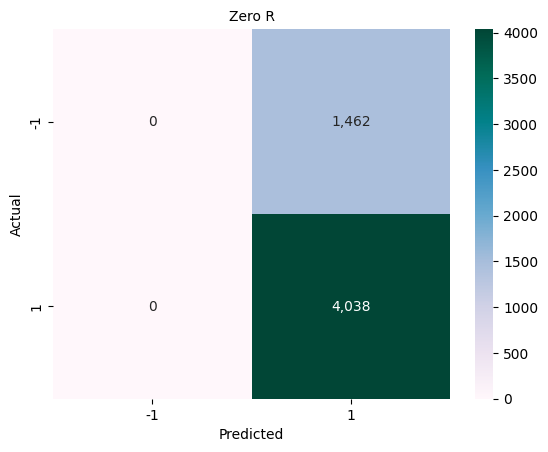

In [28]:
data_cm = confusion_matrix(data_test['rating'], prediction)
s = sn.heatmap(data_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='PuBuGn')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Zero R', fontsize=10)

<h5> Note </h5>

As the dataset is heavily unbalance toward the negative outcome, recall is an important metrics because high recall means there is low false negative, which means negative cases are being labelled correctly; which is important because we are interested in knowing which review is negative with regards to the context of the md review dataset.



Each review is assumed to be a unique patient.

Sampling strategy is as follow:

Reviews are obtained from 2 websites: yelp.come and ratemds.com. Only internal medicine doctors and family medicine doctors are included in the dataset. The list of doctors are generated for a given city by using ZIP codes of the city in the search. Four US cities are chosen to represent different geographical regions; they are San Francisco, Atlanta, Chicago and NY. 

Sampling: To avoid bias introduced by physicians with large number of reviews, up to first three reviews available are included for any given physician. From the search results, 30 doctors are selected from the top result, 40 are selected from the middle, and 30 are selected from the end of the list.

<h4> Feature selection using Chi Square and Mutual Information (Filtering methods)</h4> 

In [17]:
vectoriser = CountVectorizer(stop_words='english')
x_train = vectoriser.fit_transform(data_train['review-text-cleaned'])
x_test = vectoriser.transform(data_test['review-text-cleaned'])
y_train = data_train['rating']
y_test = data_test['rating']

x2 = SelectKBest(chi2, k=50)
X_train_x2 = x2.fit_transform(x_train,y_train)
X_test_x2 = x2.transform(x_test)

for feat_num in x2.get_support(indices=True):
    print(vectoriser.get_feature_names_out()[feat_num])

63
appointment
arrogant
asked
bad
best
blood
called
caring
did
didn
dr
excellent
friendly
got
great
helpful
highly
horrible
insurance
knowledgeable
later
left
listens
love
medication
money
pain
poor
quot
records
refused
room
rude
said
takes
terrible
test
thorough
told
tried
uncaring
unprofessional
wanted
waste
went
wonderful
worse
worst
wrong


In [18]:
mi = SelectKBest(score_func=mutual_info_classif, k=50)
X_train_mi = mi.fit_transform(x_train,y_train)
X_test_mi = mi.transform(x_test)

print(X_test_mi.shape, X_train_mi.shape)

for feat_num in mi.get_support(indices=True):
    print(vectoriser.get_feature_names_out()[feat_num])

(5500, 50) (43003, 50)
63
amazing
arrogant
asked
bad
best
called
caring
comfortable
compassionate
did
didn
dr
excellent
friendly
got
great
helpful
highly
horrible
kind
knowledgable
knowledgeable
later
left
listens
love
money
pain
poor
professional
quot
refused
room
rude
said
takes
terrible
thorough
told
tried
uncaring
unprofessional
wanted
waste
went
wonderful
worse
worst
wrong


<h4>Gaussian Naive Bayes classifier</h4>

<h5> Benchmark - Gaussian Naive Bayes on count vectorised text with no feature selection</h5>

Classification report
              precision    recall  f1-score   support

          -1       0.29      0.84      0.43      1462
           1       0.82      0.25      0.38      4038

    accuracy                           0.41      5500
   macro avg       0.55      0.55      0.41      5500
weighted avg       0.68      0.41      0.40      5500



Text(0.5, 1.0, 'GNB Benchmark')

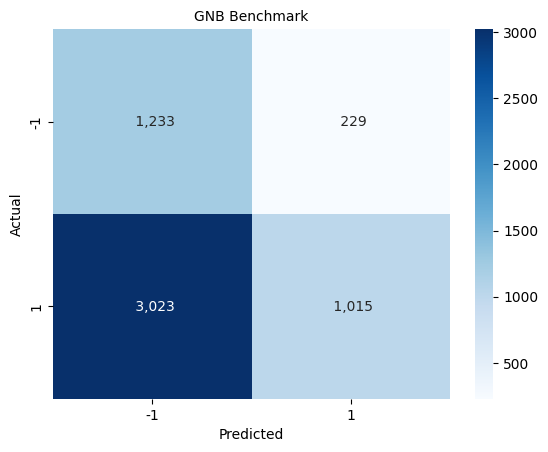

In [29]:
guassian_classifier = GaussianNB()
guassian_classifier.fit(x_train.toarray(), y_train)
base_pred = guassian_classifier.predict(x_test.toarray())
cm = confusion_matrix(y_test, base_pred)
base_report = classification_report(y_test, base_pred)
print("Classification report")
print(base_report)
s = sn.heatmap(cm, annot=True, annot_kws={"size":10}, fmt=' ,d', cmap="Blues")
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('GNB Benchmark', fontsize=10)

<h5> Mutual Information </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.76      0.67      0.71      1462
           1       0.88      0.92      0.90      4038

    accuracy                           0.86      5500
   macro avg       0.82      0.80      0.81      5500
weighted avg       0.85      0.86      0.85      5500



Text(0.5, 1.0, 'Mutual Information')

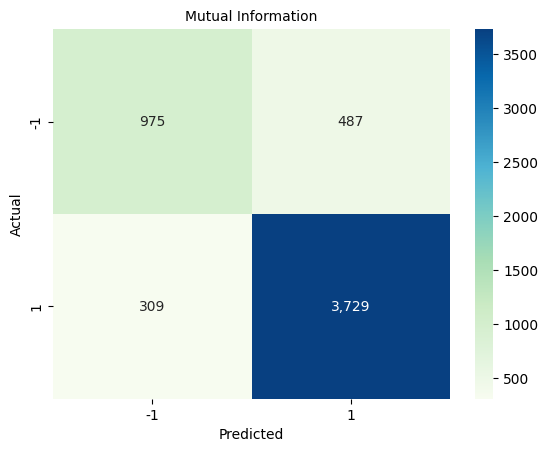

In [30]:
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(X_train_mi.toarray(), y_train)
y_test_predict = gaussian_classifier.predict(X_test_mi.toarray())
mi_cm = confusion_matrix(y_test, y_test_predict)
mi_report = classification_report(y_test, y_test_predict)
print("Classification report")
print(mi_report)
s = sn.heatmap(mi_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='GnBu')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Mutual Information', fontsize=10)

<h5> Chi Squared </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.75      0.65      0.69      1462
           1       0.88      0.92      0.90      4038

    accuracy                           0.85      5500
   macro avg       0.81      0.78      0.80      5500
weighted avg       0.84      0.85      0.84      5500



Text(0.5, 1.0, 'Chi-Square')

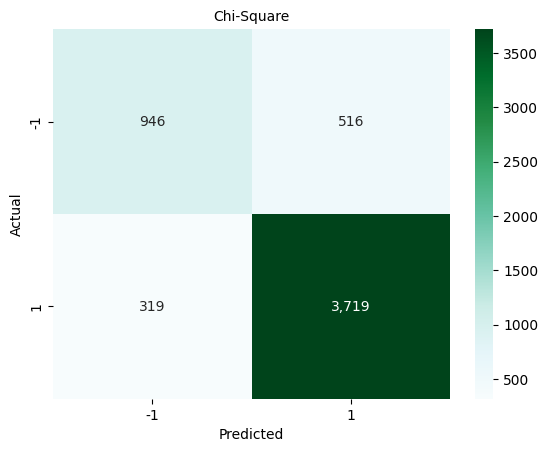

In [21]:
gaussian_classifier.fit(X_train_x2.toarray(), y_train)
y_test_predict_x2 = gaussian_classifier.predict(X_test_x2.toarray())
x2_cm = confusion_matrix(y_test, y_test_predict_x2)
x2_report = classification_report(y_test, y_test_predict_x2)
print("Classification report")
print(x2_report)
s = sn.heatmap(x2_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='BuGn')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Chi-Square', fontsize=10)

<h5>TFIDF</h5>

Classification report
              precision    recall  f1-score   support

          -1       0.67      0.89      0.77      1462
           1       0.96      0.84      0.90      4038

    accuracy                           0.86      5500
   macro avg       0.82      0.87      0.83      5500
weighted avg       0.88      0.86      0.86      5500



Text(0.5, 1.0, 'TFIDF')

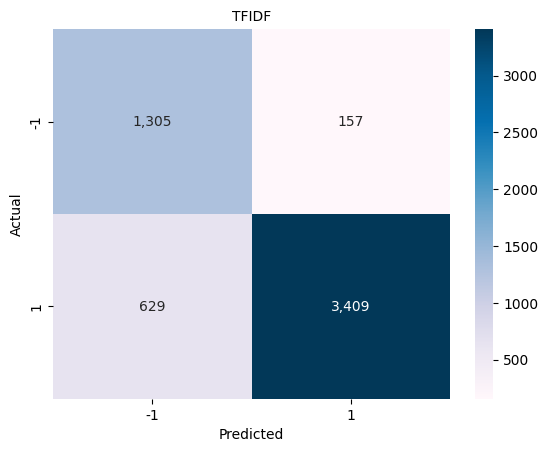

In [31]:
gaussian_classifier_t = GaussianNB()
gaussian_classifier_t.fit(tfidf_train, y_train)
y_tfidf_predict = gaussian_classifier_t.predict(tfidf_test)
tfidf_cm = confusion_matrix(y_test, y_tfidf_predict)
tfidf_report = classification_report(y_test, y_tfidf_predict)
print("Classification report")
print(tfidf_report)
s = sn.heatmap(tfidf_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='PuBu')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('TFIDF', fontsize=10)

<h5> Word Embeddings </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.69      0.89      0.78      1462
           1       0.96      0.86      0.90      4038

    accuracy                           0.87      5500
   macro avg       0.82      0.87      0.84      5500
weighted avg       0.89      0.87      0.87      5500



Text(0.5, 1.0, 'Word Embedding')

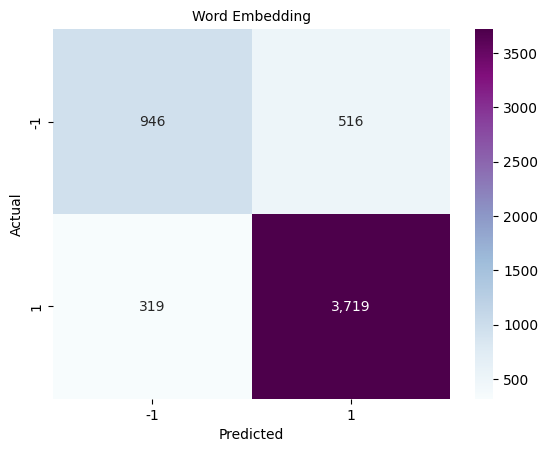

In [32]:
gaussian_classifier.fit(embedded_text_train, y_train)
y_test_predict_embedded = gaussian_classifier.predict(embedded_text_test)
embedded_cm = confusion_matrix(y_test, y_test_predict_x2)
embedded_report = classification_report(y_test, y_test_predict_embedded)
print("Classification report")
print(embedded_report)
s = sn.heatmap(embedded_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='BuPu')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Word Embedding', fontsize=10)

<h4>KNN Classifier </h4>

<h5> Benchmark - KNN with no feature selection </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.71      0.49      0.58      1462
           1       0.83      0.93      0.88      4038

    accuracy                           0.81      5500
   macro avg       0.77      0.71      0.73      5500
weighted avg       0.80      0.81      0.80      5500



Text(0.5, 1.0, 'KNN Benchmark')

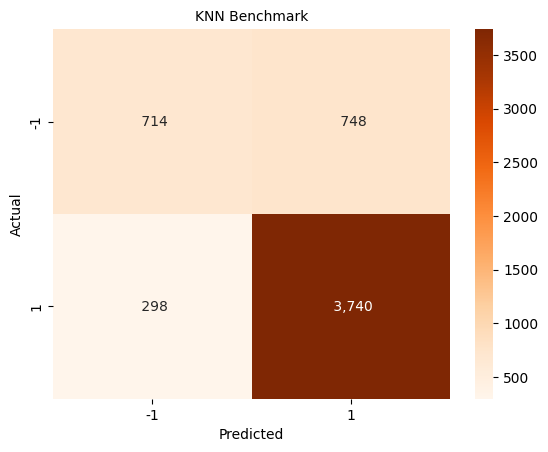

In [33]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
knn.fit(x_train, y_train)
base_knn_pred = knn.predict(x_test)
knn_base_cm = confusion_matrix(y_test, base_knn_pred)
knn_base_report = classification_report(y_test, base_knn_pred)
print("Classification report")
print(knn_base_report)
s = sn.heatmap(knn_base_cm, annot=True, annot_kws={"size":10}, fmt=' ,d', cmap="Oranges")
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('KNN Benchmark', fontsize=10)

<h5> Mutual Information </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.79      0.61      0.69      1462
           1       0.87      0.94      0.90      4038

    accuracy                           0.85      5500
   macro avg       0.83      0.78      0.80      5500
weighted avg       0.85      0.85      0.85      5500



Text(0.5, 1.0, 'Mutual Information')

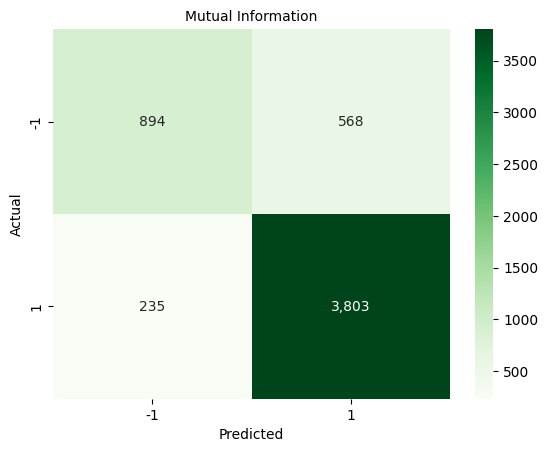

In [27]:
knn_mi = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
knn_mi.fit(X_train_mi, y_train)
knn_mi_pred = knn_mi.predict(X_test_mi)
knn_mi_cm = confusion_matrix(y_test, knn_mi_pred)
knn_mi_report = classification_report(y_test, knn_mi_pred)
print("Classification report")
print(knn_mi_report)
s = sn.heatmap(knn_mi_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Greens')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Mutual Information', fontsize=10)


<h5> Chi Squared </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.79      0.58      0.67      1462
           1       0.86      0.94      0.90      4038

    accuracy                           0.85      5500
   macro avg       0.83      0.76      0.79      5500
weighted avg       0.84      0.85      0.84      5500



Text(0.5, 1.0, 'Chi-Square')

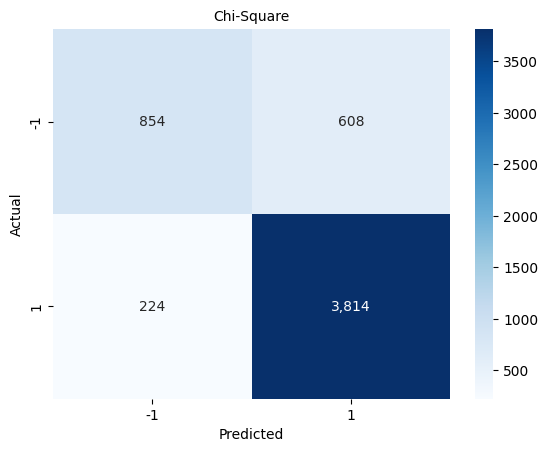

In [34]:
x2knn = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
x2knn.fit(X_train_x2, y_train)
knn_x2_pred = x2knn.predict(X_test_x2)
knn_x2_cm = confusion_matrix(y_test, knn_x2_pred)
knn_x2_report = classification_report(y_test, knn_x2_pred)
print("Classification report")
print(knn_x2_report)
s = sn.heatmap(knn_x2_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Blues')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Chi-Square', fontsize=10)


<h5> TFIDF </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.68      0.31      0.42      1462
           1       0.79      0.95      0.86      4038

    accuracy                           0.78      5500
   macro avg       0.73      0.63      0.64      5500
weighted avg       0.76      0.78      0.75      5500



Text(0.5, 1.0, 'TFIDF')

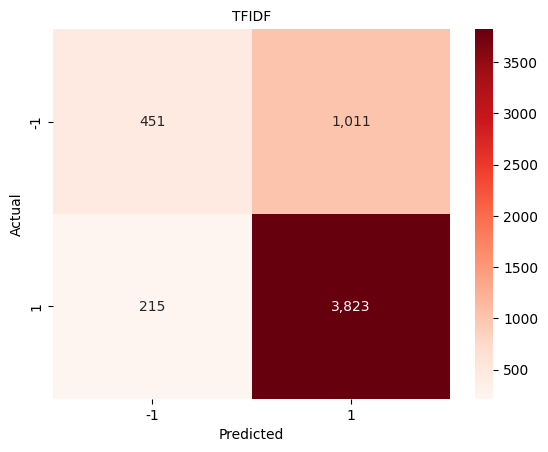

In [35]:
tfidfknn = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
tfidfknn.fit(tfidf_train, y_train)
knn_tfidf_pred = tfidfknn.predict(tfidf_test)
knn_tfidf_cm = confusion_matrix(y_test, knn_tfidf_pred)
knn_tfidf_report = classification_report(y_test, knn_tfidf_pred)
print("Classification report")
print(knn_tfidf_report)
s = sn.heatmap(knn_tfidf_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Reds')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('TFIDF', fontsize=10)

<h5> Word Embeddings </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.84      0.69      0.76      1462
           1       0.89      0.95      0.92      4038

    accuracy                           0.88      5500
   macro avg       0.87      0.82      0.84      5500
weighted avg       0.88      0.88      0.88      5500



Text(0.5, 1.0, 'Word Embedding')

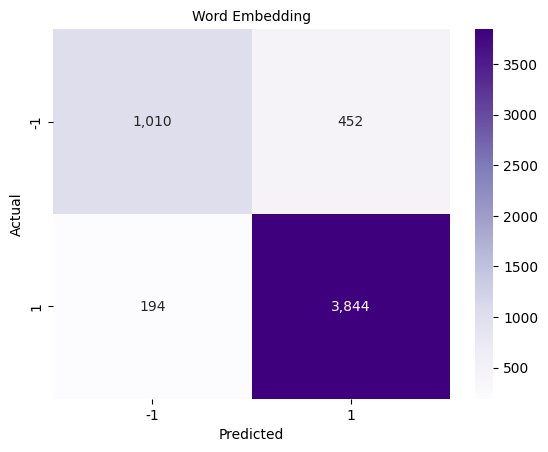

In [36]:
eknn = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
eknn.fit(embedded_text_train, y_train)
knn_embedded_pred = eknn.predict(embedded_text_test)
knn_embedded_cm = confusion_matrix(y_test, knn_embedded_pred)
knn_embedded_report = classification_report(y_test, knn_embedded_pred)
print("Classification report")
print(knn_embedded_report)
s = sn.heatmap(knn_embedded_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Purples')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Word Embedding', fontsize=10)

<h4>Embedded</h4>

<h5> Decision Tree </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.72      0.77      0.74      1462
           1       0.91      0.89      0.90      4038

    accuracy                           0.86      5500
   macro avg       0.82      0.83      0.82      5500
weighted avg       0.86      0.86      0.86      5500



Text(0.5, 1.0, 'Decision Tree')

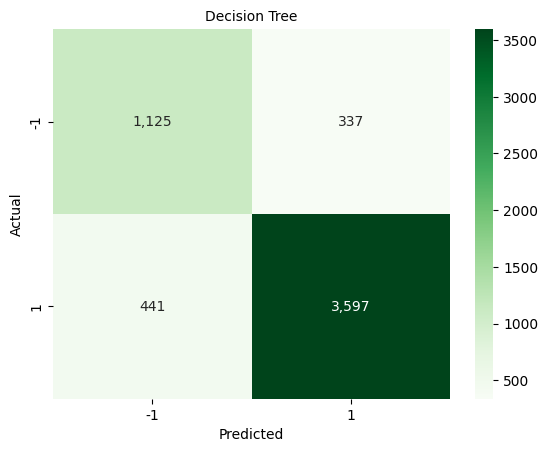

In [37]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_dt_pred = clf.predict(x_test)
dt_mi_report = classification_report(y_test, y_dt_pred)
dt_cm = confusion_matrix(y_test, y_dt_pred)
print("Classification report")
print(dt_mi_report)
s = sn.heatmap(dt_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Greens')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Decision Tree', fontsize=10)

<h4> Logistic regresion </h4>

<h5> Benchmark </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.87      0.79      0.83      1462
           1       0.93      0.96      0.94      4038

    accuracy                           0.91      5500
   macro avg       0.90      0.87      0.88      5500
weighted avg       0.91      0.91      0.91      5500



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Benchmark')

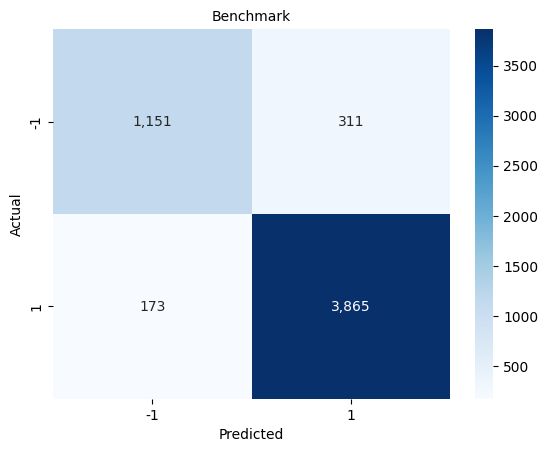

In [39]:
logist_r = LogisticRegression()
logist_r.fit(x_train, y_train)
logis_pred = logist_r.predict(x_test)
logis_cm = confusion_matrix(y_test, logis_pred)
logis_report = classification_report(y_test, logis_pred)
print("Classification report")
print(logis_report)
s = sn.heatmap(logis_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Blues')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Benchmark', fontsize=10)

<h5>Chi Square</h5>

Classification report
              precision    recall  f1-score   support

          -1       0.82      0.64      0.72      1462
           1       0.88      0.95      0.91      4038

    accuracy                           0.87      5500
   macro avg       0.85      0.80      0.82      5500
weighted avg       0.87      0.87      0.86      5500



Text(0.5, 1.0, 'Chi-Square')

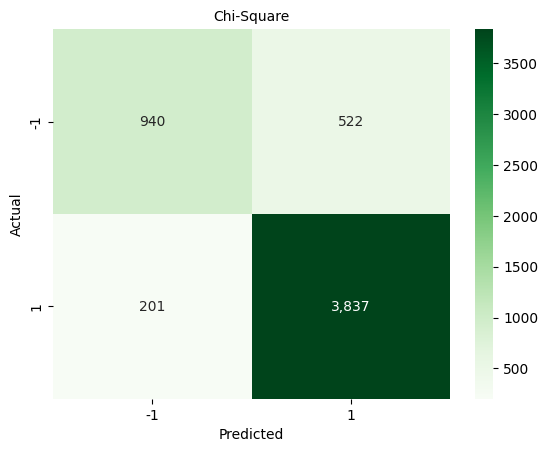

In [40]:
logist_r_x2 = LogisticRegression()
logist_r_x2.fit(X_train_x2, y_train)
logis_x2_pred = logist_r_x2.predict(X_test_x2)
logis_x2_cm = confusion_matrix(y_test, logis_x2_pred)
logis_x2_report = classification_report(y_test, logis_x2_pred)
print("Classification report")
print(logis_x2_report)
s = sn.heatmap(logis_x2_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Greens')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Chi-Square', fontsize=10)

<h5> Mutual Information </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.83      0.65      0.73      1462
           1       0.88      0.95      0.92      4038

    accuracy                           0.87      5500
   macro avg       0.85      0.80      0.82      5500
weighted avg       0.87      0.87      0.87      5500



Text(0.5, 1.0, 'Mutual Information')

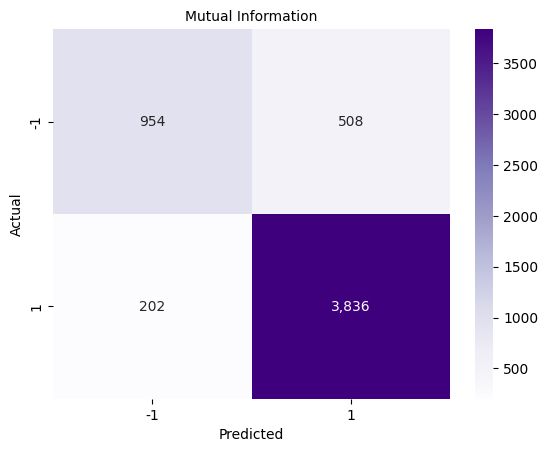

In [41]:
logist_r_mi = LogisticRegression()
logist_r_mi.fit(X_train_mi, y_train)
logis_mi_pred = logist_r_mi.predict(X_test_mi)
logis_mi_cm = confusion_matrix(y_test, logis_mi_pred)
logis_mi_report = classification_report(y_test, logis_mi_pred)
print("Classification report")
print(logis_mi_report)
smi = sn.heatmap(logis_mi_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Purples')
smi.set_ylabel('Actual', fontsize=10)
smi.set_xlabel('Predicted', fontsize=10)
smi.set_xticklabels(['-1', '1'])
smi.set_yticklabels(['-1', '1'])
smi.set_title('Mutual Information', fontsize=10)

<h5> TFIDF </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.81      0.85      0.83      1462
           1       0.94      0.93      0.94      4038

    accuracy                           0.91      5500
   macro avg       0.88      0.89      0.88      5500
weighted avg       0.91      0.91      0.91      5500



Text(0.5, 1.0, 'TFIDF')

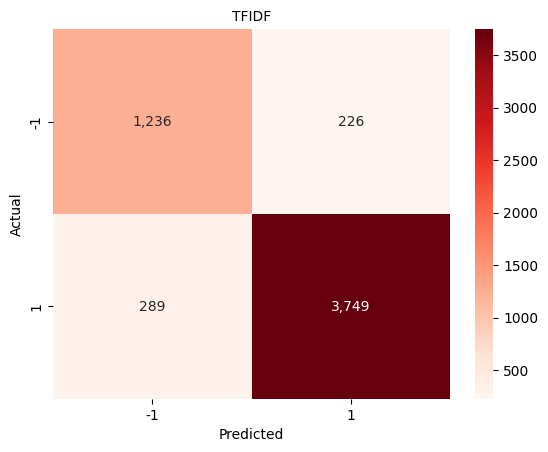

In [44]:
logist_r_tfidf = LogisticRegression()
logist_r_tfidf.fit(tfidf_train, y_train)
logis_tfidf_pred = logist_r_tfidf.predict(tfidf_test)
logis_tfidf_cm = confusion_matrix(y_test, logis_tfidf_pred)
logis_tfidf_report = classification_report(y_test, logis_tfidf_pred)
print("Classification report")
print(logis_tfidf_report)
s = sn.heatmap(logis_tfidf_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Reds')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('TFIDF', fontsize=10)

<h5> Word embedding </h5>

Classification report
              precision    recall  f1-score   support

          -1       0.86      0.83      0.85      1462
           1       0.94      0.95      0.95      4038

    accuracy                           0.92      5500
   macro avg       0.90      0.89      0.90      5500
weighted avg       0.92      0.92      0.92      5500



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Chi-Square')

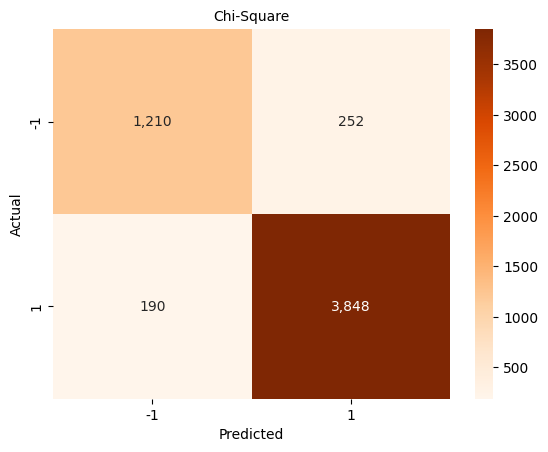

In [45]:
logist_r_e = LogisticRegression()
logist_r_e.fit(embedded_text_train, y_train)
logis_embedded_pred = logist_r_e.predict(embedded_text_test)
logis_embedded_cm = confusion_matrix(y_test, logis_embedded_pred)
logis_embedded_report = classification_report(y_test, logis_embedded_pred)
print("Classification report")
print(logis_embedded_report)

s = sn.heatmap(logis_embedded_cm, annot=True, annot_kws={"size": 10}, fmt= ',d', cmap='Oranges')
s.set_ylabel('Actual', fontsize=10)
s.set_xlabel('Predicted', fontsize=10)
s.set_xticklabels(['-1', '1'])
s.set_yticklabels(['-1', '1'])
s.set_title('Chi-Square', fontsize=10)

<h2>Kaggle </h2>

<h4> Decision Tree </h4>

In [72]:
kaggle_data = pd.read_csv('TEST_NO_LABELS.csv', index_col=0)

x_test_k = vectoriser.transform(kaggle_data['review-text-cleaned'])

kaggle_dt_pred = clf.predict(x_test_k)

dt_df = pd.DataFrame(kaggle_dt_pred)
dt_df.index.names = ['id']
dt_df.to_csv("kaggle_submission.csv", index=True, header=["rating"])

<h4> Pure logistic </h4>

In [124]:
b_pred = logist_r.predict(x_test_k)

b_df = pd.DataFrame(b_pred)
b_df.index.names = ['id']
b_df.to_csv("benchmark.csv", index=True, header=['rating'])

<h4> KNN with 384 embedding </h4>

In [81]:
kaggle_embedded = pd.read_csv('384EMBEDDINGS_TEST.csv', index_col=0)

kaggle_knn_pred = eknn.predict(kaggle_embedded)

knn_pred = pd.DataFrame(kaggle_knn_pred)
knn_pred.index.names = ['id']
knn_pred.to_csv("kaggle_knn.csv", index=True, header=["rating"])

<h4>Logistic with 384 embedding</h4>

In [87]:
kaggle_logistic_pred = logist_r_e.predict(kaggle_embedded)

kaggle_logis_pred = pd.DataFrame(kaggle_logistic_pred)
kaggle_logis_pred.index.names = ['id']
kaggle_logis_pred.to_csv("kaggle_logistic.csv", index=True, header=["rating"])

<h4> GNB with TFIDF </h4>

In [93]:
k_tfidf = pd.read_csv("TFIDF_TEST.csv", index_col=0)

kaggle_gnb_pred = gaussian_classifier_t.predict(k_tfidf)

kaggle_tfidf_pred = pd.DataFrame(kaggle_gnb_pred)
kaggle_tfidf_pred.index.names = ["id"]
kaggle_tfidf_pred.to_csv("kaggle_gnb.csv", index=True, header=["rating"])

<h4> Logistic with TFIDF </h4>

In [95]:
tfidf_lr_pred = logist_r_tfidf.predict(k_tfidf)

tfidf_df = pd.DataFrame(tfidf_lr_pred)
tfidf_df.index.names = ["id"]
tfidf_df.to_csv("tfidf_lr_kaggle.csv", index=True, header=['rating'])
